<a href="https://colab.research.google.com/github/shobhittya/deeplearning/blob/main/Deepfake_DenseNET_Aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

In [2]:
!nvidia-smi

Sat Oct 30 05:19:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

In [5]:
dataset_url = "https://www.kaggle.com/xhlulu/140k-real-and-fake-faces"

In [6]:
import os

In [7]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 3.75G/3.75G [00:31<00:00, 129MB/s] 


In [16]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.6.0


**FAKE SET**

In [18]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20

TRAIN_PATH = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
TEST_PATH = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'
VALID_PATH = '/content/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'

DF_TRAIN = pd.read_csv('/content/140k-real-and-fake-faces/train.csv', dtype='str')
TEST_IMAGES = glob.glob(TEST_PATH + '/*.jpg')
DF_TEST = pd.DataFrame(TEST_IMAGES, columns = ['image_path'])

classes = {0 : "Real",
           1 : "Fake"}

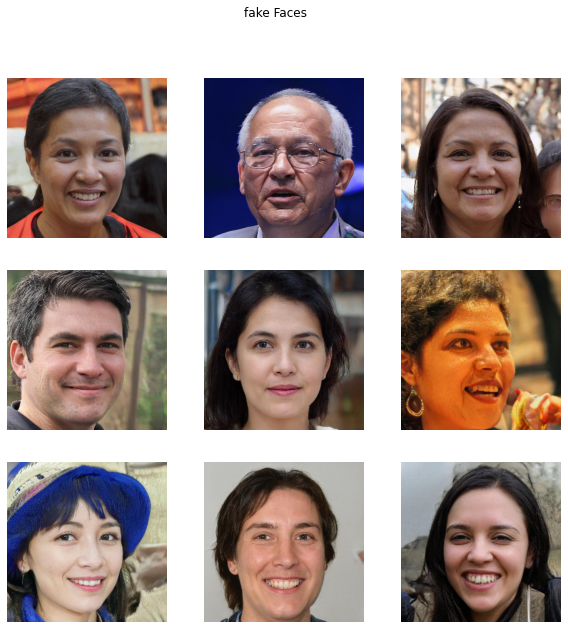

In [9]:
plot_img(path, 'fake').show()

**Data Augmentation**

In [11]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)

In [19]:
bs = 64
row, col = 128, 128
training_set = datagen.flow_from_directory(TRAIN_PATH,
                                                 class_mode='binary',
                                                 shuffle=True,
                                                 target_size=(row,col),
                                                 batch_size=bs
                                                )
val_test_datagen = ImageDataGenerator(rescale=1./255)

validation_set = datagen.flow_from_directory(VALID_PATH,
                                                      class_mode='binary',
                                                      shuffle=True,
                                                      target_size=(row,col),
                                                      batch_size=bs
                                                     ) 
test_set = datagen.flow_from_directory(TEST_PATH,
                                                class_mode='binary',
                                                shuffle=True,
                                                target_size=(row,col),
                                                batch_size=bs
                                               )
training_set.class_indices

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


{'fake': 0, 'real': 1}

**Model Architecture**

In [28]:
from tensorflow.keras.applications import DenseNet121
def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(224,224,3)
                          )
    model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        Dropout(0.3),
                                        Dense(1, activation='sigmoid')
                                      ])


    return model
model = get_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 7,564,865
Trainable params: 7,480,193
Non-trainable params: 84,672
_______________________________________

**Defining Model Checkpoints**

In [29]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = training_set.n // training_set.batch_size
STEP_SIZE_VALID = validation_set.n // validation_set.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 2,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer] 



**Training model**

In [31]:
hist = model.fit(x = training_set,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = validation_set, 
          validation_steps = STEP_SIZE_VALID,
          epochs =10 , 
          callbacks = callbacks) 


Epoch 1/10
1562/1562 [==============================] - 1492s 955ms/step - loss: 0.4658 - accuracy: 0.8951 - val_loss: 0.4293 - val_accuracy: 0.9150

Epoch 00001: val_accuracy improved from -inf to 0.91501, saving model to ./model.hdf5
Epoch 2/10
1562/1562 [==============================] - 1471s 942ms/step - loss: 0.4076 - accuracy: 0.9446 - val_loss: 0.3886 - val_accuracy: 0.9535

Epoch 00002: val_accuracy improved from 0.91501 to 0.95348, saving model to ./model.hdf5
Epoch 3/10
1562/1562 [==============================] - 1461s 935ms/step - loss: 0.3836 - accuracy: 0.9605 - val_loss: 0.5320 - val_accuracy: 0.8255

Epoch 00003: val_accuracy did not improve from 0.95348
Epoch 4/10
1562/1562 [==============================] - 1460s 935ms/step - loss: 0.3680 - accuracy: 0.9709 - val_loss: 0.3697 - val_accuracy: 0.9629

Epoch 00004: val_accuracy improved from 0.95348 to 0.96289, saving model to ./model.hdf5
Epoch 5/10
1562/1562 [==============================] - 1456s 932ms/step - loss: 

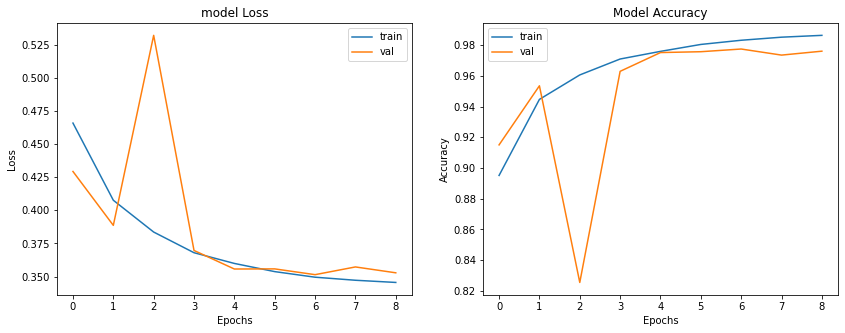

In [32]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

**Accuracy On Test Set**

In [35]:
_, accu = model.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 209s 668ms/step - loss: 0.3503 - accuracy: 0.9798
Final Test Acccuracy = 97.985


**Confusion Matrix and Classification Report**

Confusion Matrix
[[5001 4999]
 [5014 4986]]
Classification Report
              precision    recall  f1-score   support

        fake       0.50      0.50      0.50     10000
        real       0.50      0.50      0.50     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



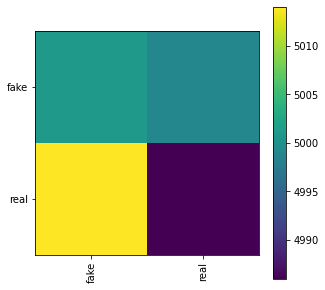

In [36]:
y_pred = model.predict(test_set)
y_pred = (y_pred < 0.5).astype(np.int)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm)

names = ['fake', 'real']
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=names))

plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.colorbar()
tick_mark = np.arange(len(names))
_ = plt.xticks(tick_mark, names, rotation=90)
_ = plt.yticks(tick_mark, names)
